In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import jax
import jax.numpy as jnp
import arviz as az


/mnt/home/cmodi/miniconda3/envs/jaxlatest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import jaxoplanet
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro_ext.distributions, numpyro_ext.optim
import jax
import jax.numpy as jnp
import corner
import arviz as az
import copy

numpyro.set_host_device_count(
    2
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)  # For 64-bit precision since JAX defaults to 32-bit


print(f"jaxoplanet.__version__ = {jaxoplanet.__version__}")
print(f"numpy.__version__ = {np.__version__}")
print(f"matplotlib.__version__ = {plt.matplotlib.__version__}")
print(f"numpyro.__version__ = {numpyro.__version__}")
print(f"numpyro_ext.__version__ = {numpyro_ext.__version__}")
print(f"jax.__version__ = {jax.__version__}")
print(f"corner.__version__ = {corner.__version__}")
print(f"arviz.__version__ = {az.__version__}")


jaxoplanet.__version__ = 0.0.2
numpy.__version__ = 1.26.4
matplotlib.__version__ = 3.8.4
numpyro.__version__ = 0.14.0
numpyro_ext.__version__ = 0.0.4
jax.__version__ = 0.4.26
corner.__version__ = 2.2.2
arviz.__version__ = 0.18.0


In [5]:
zero_key = jax.random.PRNGKey(0)


# simple light curve

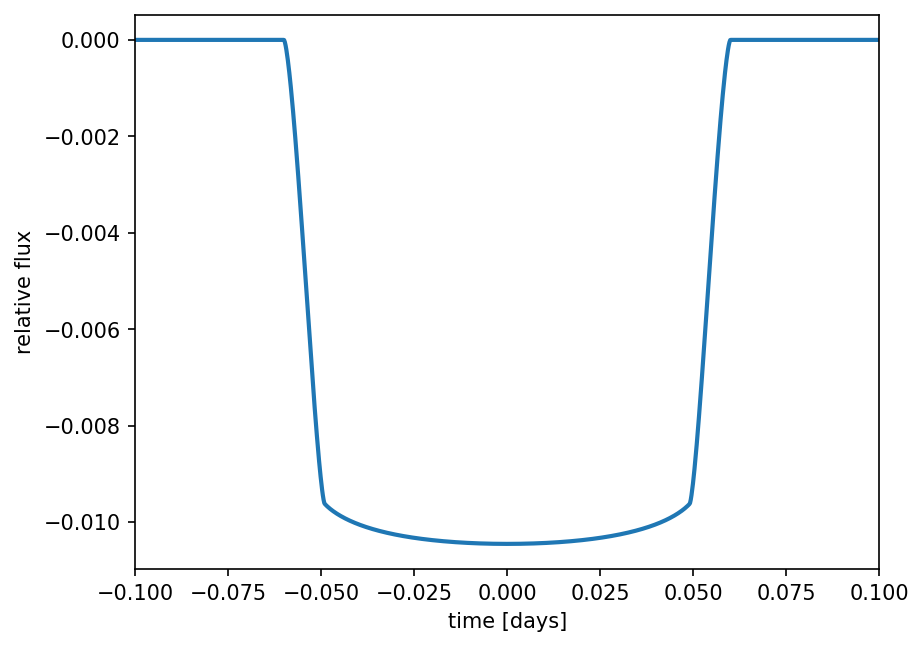

In [6]:
# The light curve calculation requires an orbit object.
# We'll use TransitOrbit (similar to SimpleTransitOrbit in the exoplanet package),
# which is an orbit parameterized by the observables of a transiting system:
# period, speed/duration, time of transit, impact parameter, and radius ratio.
orbit = TransitOrbit(
    period=3.456, duration=0.12, time_transit=0.0, impact_param=0.0, radius=0.1
)  # TODO: Is it actually the radius ratio?


# Compute a limb-darkened light curve for this orbit
t = np.linspace(-0.1, 0.1, 1000)
u = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, u)(t)

# Plot the light curve
plt.figure(dpi=150)
plt.plot(t, light_curve, lw=2)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim(t.min(), t.max());


# transit model in numpyro

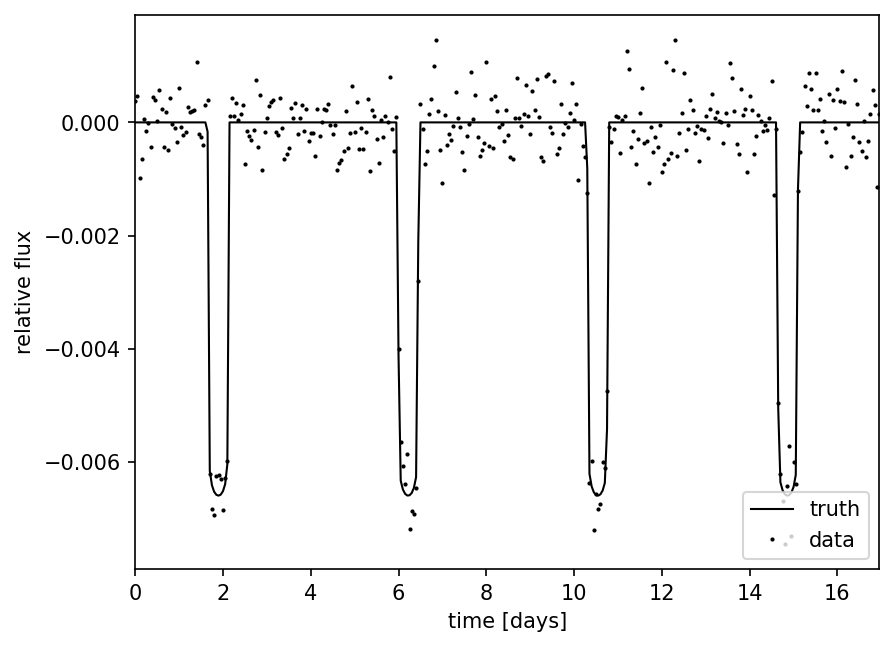

In [7]:
# Simulate some data with Gaussian noise
random = np.random.default_rng(42)
PERIOD = random.uniform(2, 5)  # day
T0 = PERIOD * random.uniform()  # day
DURATION = 0.5  # day
B = 0.5  # impact parameter
ROR = 0.08  # planet radius / star radius
U = np.array([0.1, 0.06])  # limb darkening coefficients
yerr = 5e-4  # flux uncertainty
t = np.arange(0, 17, 0.05)  # day


orbit = TransitOrbit(
    period=PERIOD, duration=DURATION, time_transit=T0, impact_param=B, radius=ROR
)
y_true = limb_dark_light_curve(orbit, U)(t)
y = y_true + yerr * random.normal(size=len(t))

# Let's see what the light curve looks like
plt.figure(dpi=150)
plt.plot(t, y_true, "-k", lw=1.0, label="truth")
plt.plot(t, y, ".k", ms=2, label="data")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.xlim(t.min(), t.max())
plt.legend(loc=4);


# define the model

In [8]:
# plt.hist(numpyro_ext.distributions.QuadLDParams().sample(zero_key, (1000,))[:, 1])

In [9]:
def model(t, yerr, y=None):
    # Priors for the parameters we're fitting for

    # The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(T0, 1))

    # The period
    logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(PERIOD), 0.1))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # The duration
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    r = numpyro.sample("r", numpyro.distributions.Uniform(0.01, 0.2))

    # The impact parameter
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1.0))
    b = numpyro.deterministic("b", _b * (1 + r))
    
    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    # The orbit and light curve
    orbit = TransitOrbit(
        period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
    )
    y_pred = limb_dark_light_curve(orbit, u)(t)

    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

In [10]:
# def model(t, yerr, y=None):
#     # Priors for the parameters we're fitting for

#     # The time of reference transit
#     t0 = numpyro.sample("t0", numpyro.distributions.Normal(T0, 1))

#     # The period
#     logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(PERIOD), 0.1))
#     period = numpyro.deterministic("period", jnp.exp(logP))

#     # The duration
#     logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1))
#     duration = numpyro.deterministic("duration", jnp.exp(logD))

#     # The radius ratio
#     # logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.5))
#     # r = numpyro.deterministic("r", jnp.exp(logR))
#     r = numpyro.sample("r", numpyro.distributions.Uniform(0.01, 0.2))

#     # The impact parameter
#     # b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1.0))
#     # logb = numpyro.sample("logb", numpyro.distributions.Normal(-0.5, 0.5))
#     # b = numpyro.deterministic("b", jnp.exp(logb) * (1 + r))
#     _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1.0))
#     b = numpyro.deterministic("b", _b * (1 + r))
    
#     # The limb darkening coefficients
#     q1 = numpyro.sample("q1", numpyro.distributions.Uniform(0, 1.0))
#     q2 = numpyro.sample("q2", numpyro.distributions.Uniform(0, 1.0))
#     u1 = numpyro.deterministic("u1", jnp.sqrt(q1) * 2 * q2)
#     u2 = numpyro.deterministic("u2", jnp.sqrt(q1) * (1-2 * q2))
#     u = numpyro.deterministic("u", jnp.stack([u1, u2]))

#     # The orbit and light curve
#     orbit = TransitOrbit(
#         period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
#     )
#     y_pred = limb_dark_light_curve(orbit, u)(t)

#     # Let's track the light curve
#     numpyro.deterministic("light_curve", y_pred)

#     # The likelihood function assuming Gaussian uncertainty
#     numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

# check priors

In [11]:
n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), t, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

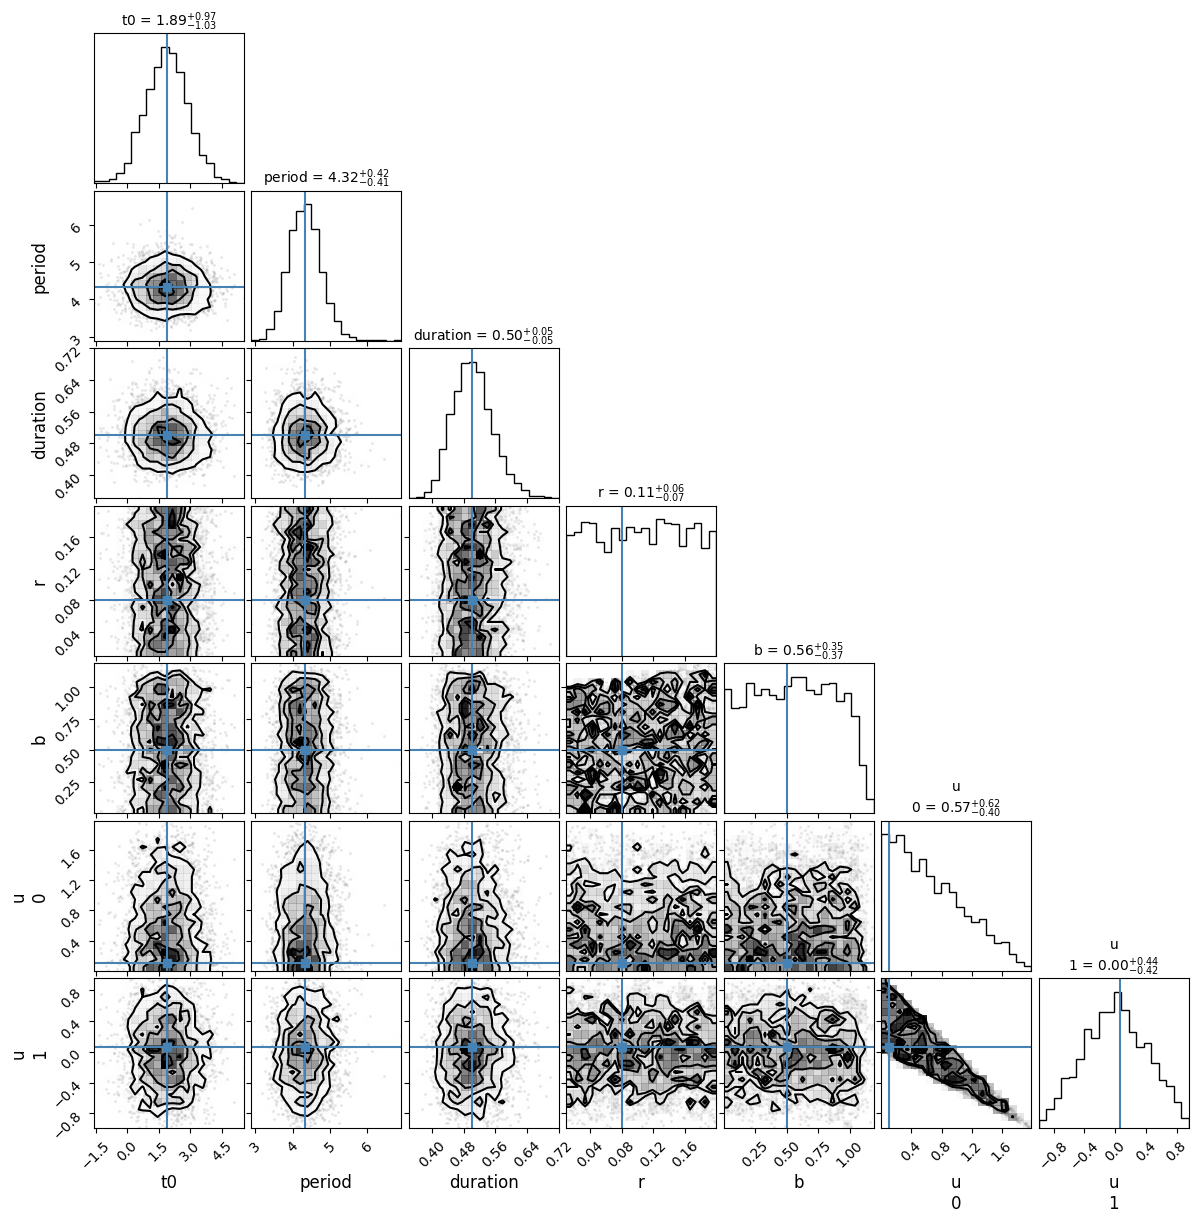

In [12]:
# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
)

# optimize

In [13]:
init_param_method = "true_values"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        "t0": T0,
        "logP": jnp.log(PERIOD),
        "logD": jnp.log(DURATION),
        "logR": jnp.log(ROR),
        "_b": B / (1 + ROR),
        "u": U,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), t, yerr, y=y)



Starting from the true values


In [14]:
for k, v in opt_params.items():
    if k in ["light_curve", "obs", "_b"]:
        continue
    print(f"{k}: {v}")

t0: 1.9000778724033895
logP: 1.4632457135160681
logD: -0.6800678396181157
r: 0.0805869891771916
u: [ 0.24748829 -0.12374414]
b: 0.5938904995145325
duration: 0.50658262482805
period: 4.319958144846175


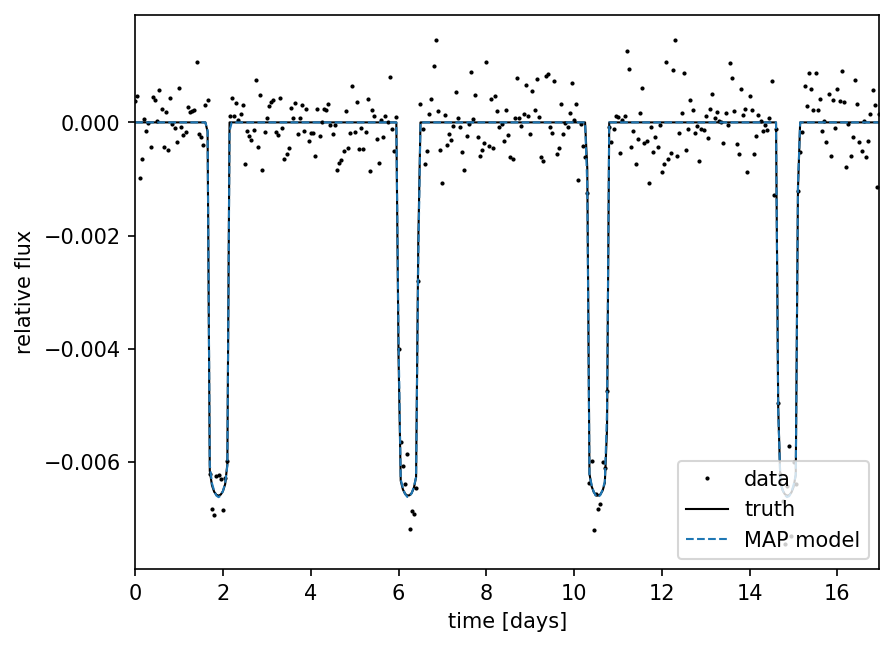

In [15]:
plt.figure(dpi=150)
plt.plot(t, y, ".k", ms=2, label="data")
plt.plot(t, y_true, "-k", lw=1.0, label="truth")
plt.plot(t, opt_params["light_curve"], "--C0", lw=1.0, label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(t.min(), t.max());

# Sampling

In [75]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), t, yerr, y=y)

Running chain 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:06<00:00, 45.03it/s]


# Checking posterior

In [17]:
var_names=["t0", "period", "duration", "r", "b", "u"]

In [18]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["t0", "period", "duration", "r", "b", "u"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,1.901,0.003,1.895,1.906,0.000,0.000,2129.0,1863.0,1.00
period,4.320,0.002,4.317,4.323,0.000,0.000,1834.0,2069.0,1.00
duration,0.505,0.006,0.493,0.517,0.000,0.000,1074.0,673.0,1.00
r,0.079,0.001,0.077,0.081,0.000,0.000,486.0,927.0,1.00
b,0.435,0.177,0.063,0.671,0.009,0.006,407.0,461.0,1.01
u[0],0.152,0.109,0.000,0.347,0.002,0.002,1917.0,1784.0,1.00
u[1],0.154,0.201,-0.170,0.538,0.006,0.005,1036.0,1459.0,1.00


In [19]:
posterior_samples_nuts = samples.copy()

In [20]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.40      0.16      0.45      0.12      0.63    375.67      1.01
      logD     -0.68      0.01     -0.68     -0.70     -0.66   1027.77      1.00
      logP      1.46      0.00      1.46      1.46      1.46   1704.05      1.00
         r      0.08      0.00      0.08      0.08      0.08    486.45      1.00
        t0      1.90      0.00      1.90      1.90      1.91   2048.61      1.00
      u[0]      0.15      0.11      0.13      0.00      0.31   1959.97      1.00
      u[1]      0.15      0.20      0.12     -0.16      0.46    951.38      1.00

Number of divergences: 0


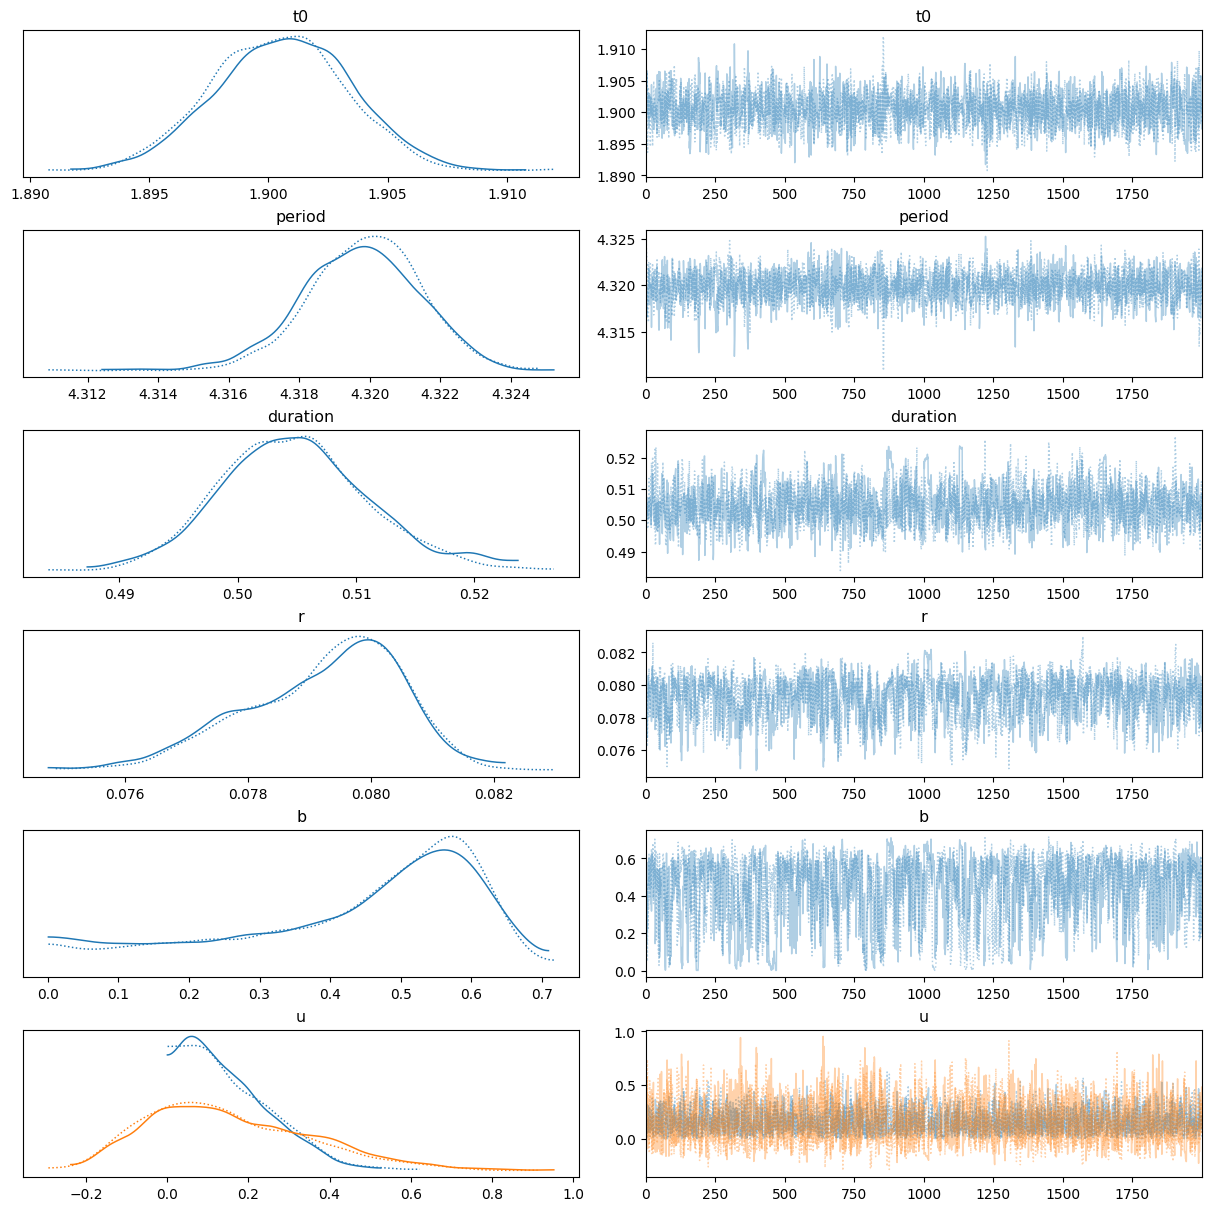

In [21]:
az.plot_trace(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
);

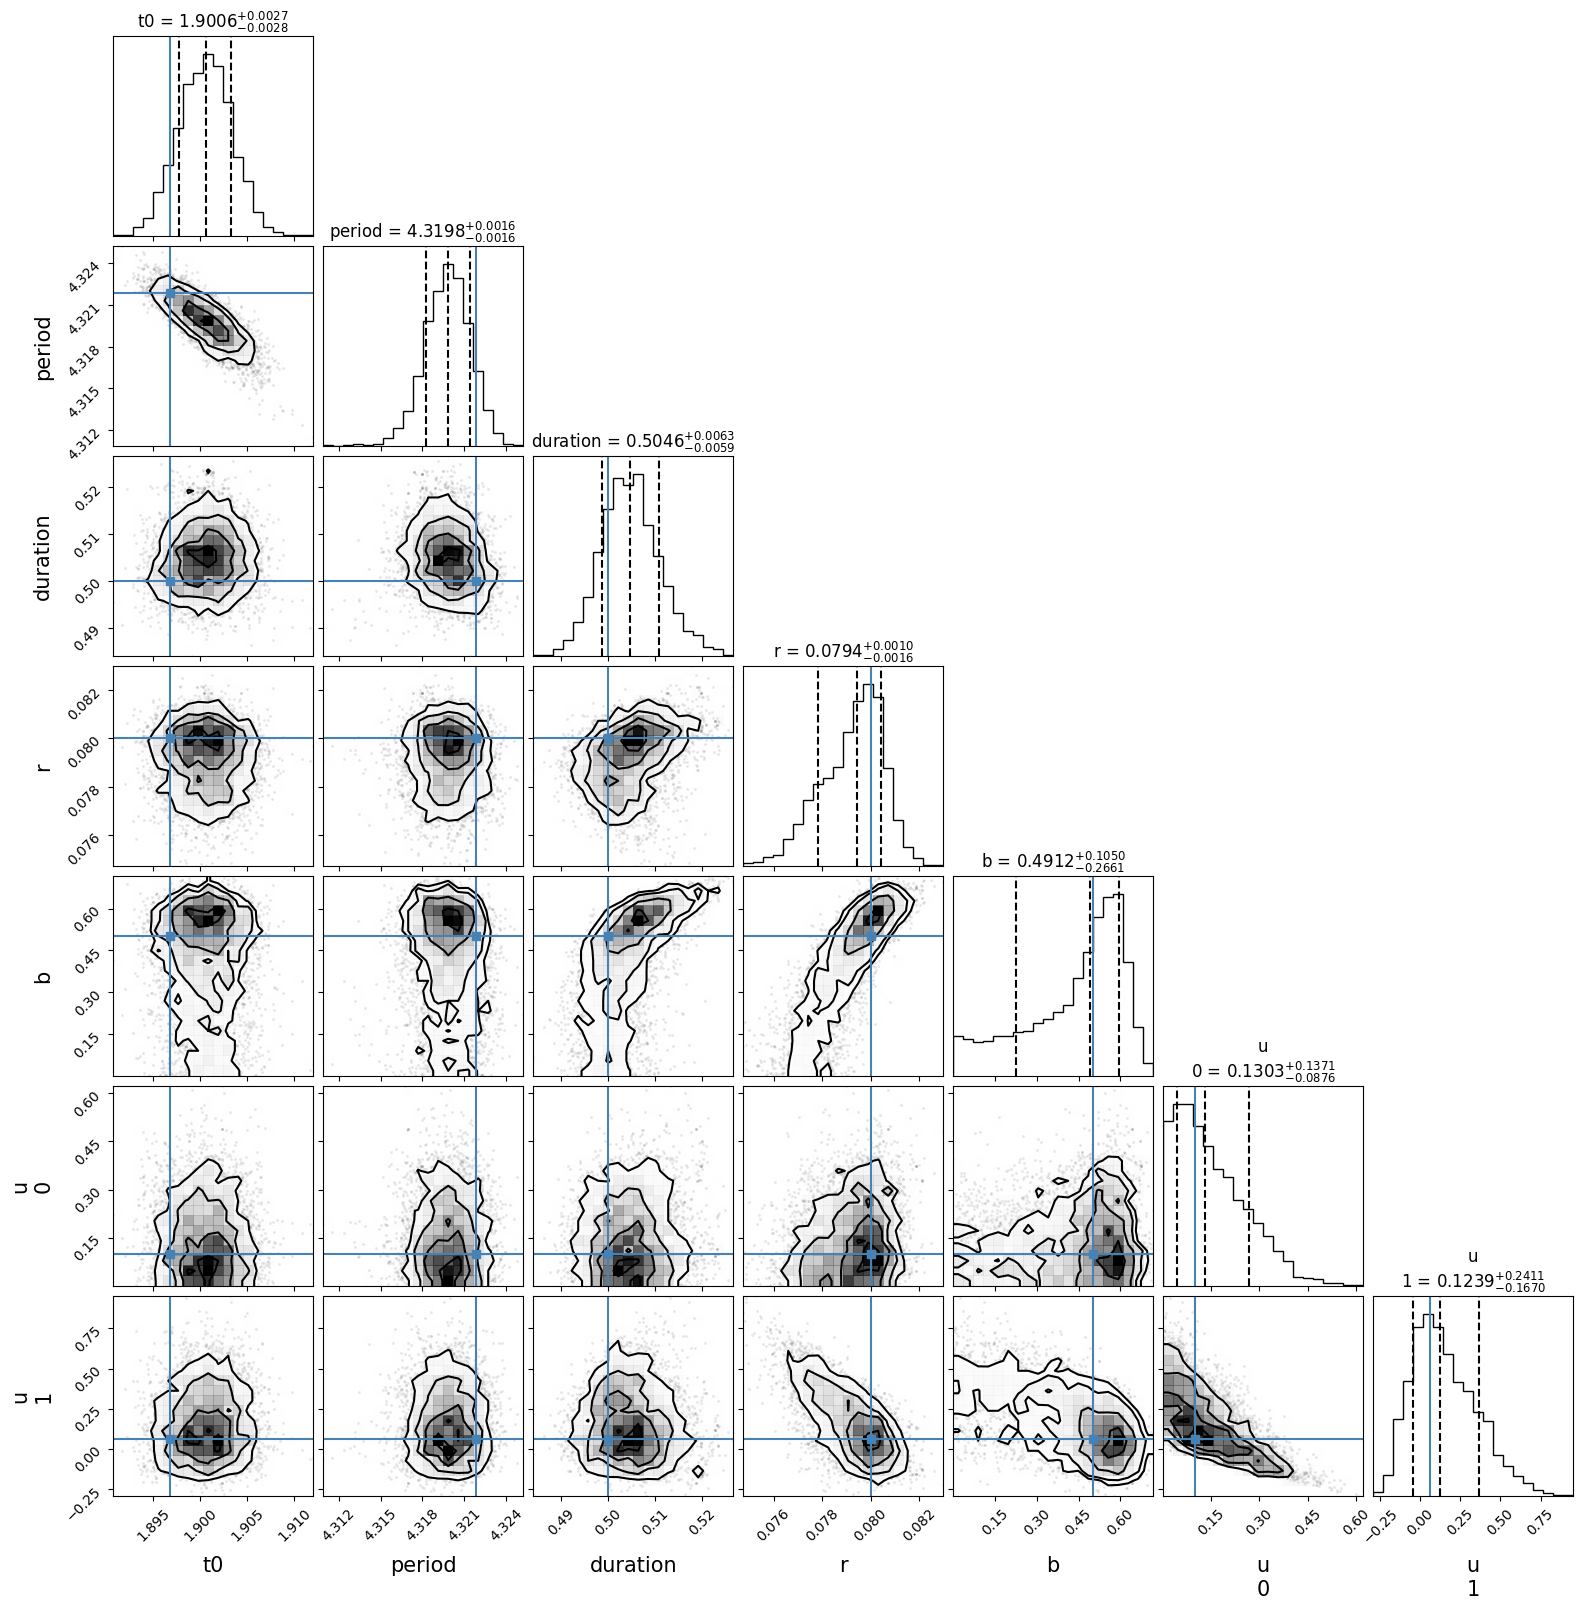

In [22]:
corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);


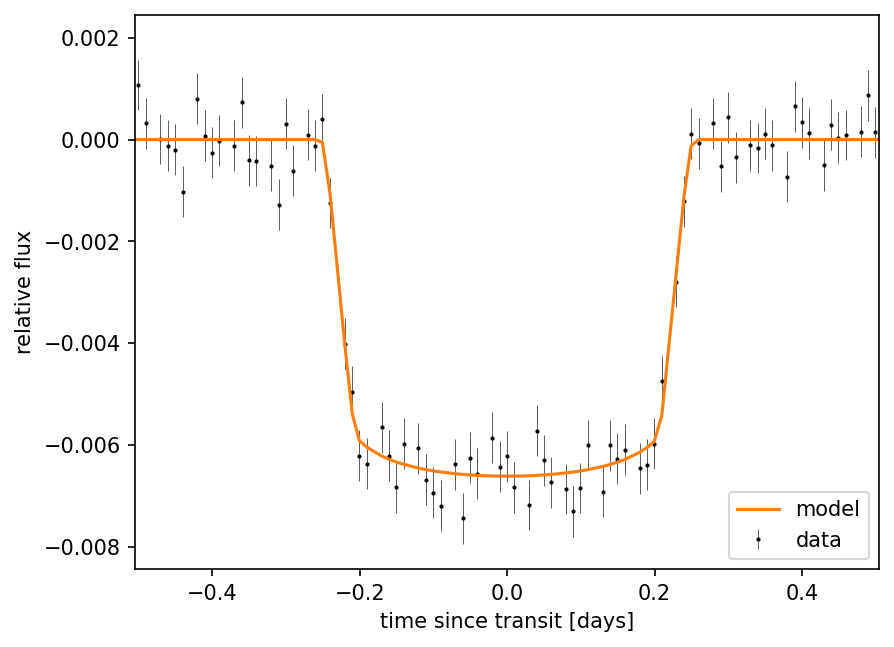

In [23]:
inferred_t0 = np.median(samples["t0"])
inferred_period = np.median(samples["period"])
inferred_duration = np.median(samples["duration"])
inferred_r = np.median(samples["r"])
inferred_b = np.median(samples["b"])
inferred_u = np.median(samples["u"], axis=0)

orbit = TransitOrbit(
    period=inferred_period,
    duration=inferred_duration,
    time_transit=inferred_t0,
    impact_param=inferred_b,
    radius=inferred_r,
)
y_model = limb_dark_light_curve(orbit, inferred_u)(t)

fig, ax = plt.subplots(dpi=150)

# Plot the folded data
t_fold = (
    t - inferred_t0 + 0.5 * inferred_period
) % inferred_period - 0.5 * inferred_period
ax.errorbar(
    t_fold,
    y,
    yerr=yerr,
    marker=".",
    ls="none",
    color="k",
    capsize=0,
    ms=2,
    lw=0.3,
    alpha=1,
    label="data",
    zorder=-100,
)

# Plot the folded model
inds = np.argsort(t_fold)
ax.plot(t_fold[inds], y_model[inds], color="C1", lw=1.5, label="model")
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux")
ax.legend(fontsize=10, loc=4)
ax.set_xlim(-inferred_duration, inferred_duration);

# sample uniform

In [24]:
import sys
sys.path.append('../../../ADSampler/adsampler/algorithms/')
from hmc import HMC


from numpyro import distributions
from jax import jit, grad

import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax import bijectors as bj

# sys.path.append('../../../hmc/src/')
# from algorithms import HMC

In [25]:
def logit(x):
    # assert (0 < x < 1)
    # return np.log(x/(1-x))
    return jnp.log(x) - jnp.log(1-x)

def logit_inverse(x):
    return 1 / (1 + jnp.exp(-x))

def unconstrain_bounded(x, a, b):
    y = (x-a)/(b-a)
    return logit(y)

def constrain_bounded(y, a, b):
    x = a + (b-a) * logit_inverse(y)
    return x

# def unconstrain_bounded_bijector(a, b):
#     shift = a
#     scale = 1/(b-a)
#     bj.Chain([bj.Logit(), bj.Scale(scale=scale), bj.Shift(shift=shit)])
    
def constrain_bounded_bijector(a, b):
    shift = a
    scale = b-a
    transform = bj.Chain([bj.Shift(shift=shift), bj.Scale(scale=scale), bj.Sigmoid()])
    return transform



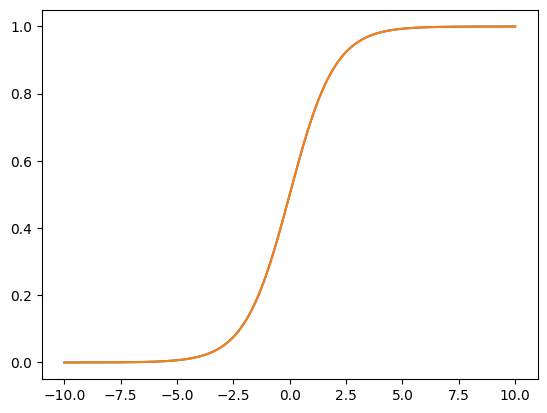

In [26]:
a, b = 0, 1
tmp = constrain_bounded_bijector(a, b)

x = np.linspace(-10, 10, 10000)
plt.plot(x, tmp(x))
plt.plot(x, constrain_bounded(x.flatten(), a, b))

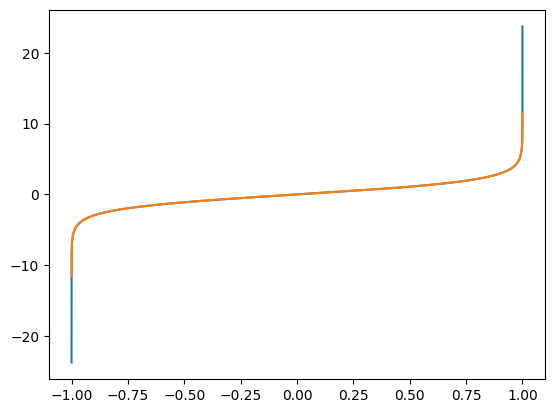

In [27]:
a, b = -1, 1
x = np.linspace(a+1e-10, b-1e-10, 100000)
plt.plot(x, unconstrain_bounded(x, a, b))
plt.plot(x, constrain_bounded_bijector(a, b).inverse(x))

In [28]:
transform = constrain_bounded_bijector(a, b)
transform(x, dtype=np.float32)

Array([-0.46211714, -0.46210927, -0.4621014 , ...,  0.46210146,
        0.46210933,  0.4621172 ], dtype=float32)

In [29]:
##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
a, b = 0, 2
# @jit
def lp_uniform(x):
    
    transform = constrain_bounded_bijector(a, b)
    u = transform(x)
    ldj = transform.forward_log_det_jacobian(x)
    lp =  distributions.Uniform(0, 1).log_prob(u)
    # lp =  distributions.Normal(0, 1).log_prob(x)
    return jnp.sum(lp + ldj)

lp_g_uniform = jit(jax.grad(lp_uniform, argnums=0))

lp = lambda x: np.squeeze(lp_uniform(x.astype(float32)).flatten())
lp_g = lambda x: lp_g_uniform(x.astype(float32)).flatten()


In [30]:
lp_uniform(jnp.array([1.2], dtype=float32)), lp_g(jnp.array([1.2], dtype=float32))

(Array(-1.0334177, dtype=float32), Array([-0.5370496], dtype=float32))

In [31]:
lp_uniform(x)

Array(-77449.25, dtype=float32)

In [32]:
# kernel = HMC(1, lp_uniform, lp_g)
kernel = HMC(1, lp, lp_g)
q0 = jnp.array([.1], dtype=float32)
sampler = kernel.sample(q0, step_size=0.1, n_samples=1000, burnin=10, nleap=10, verbose=True)

EXCEPTION IN (/mnt/home/cmodi/Research/Projects/ADSampler/adsampler/util.py, LINE 34 "self.__dict__[key] = np.array(self.__dict__[key])"): setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1000, 2) + inhomogeneous part.


In [33]:
sampler.samples.shape

(1000, 1)

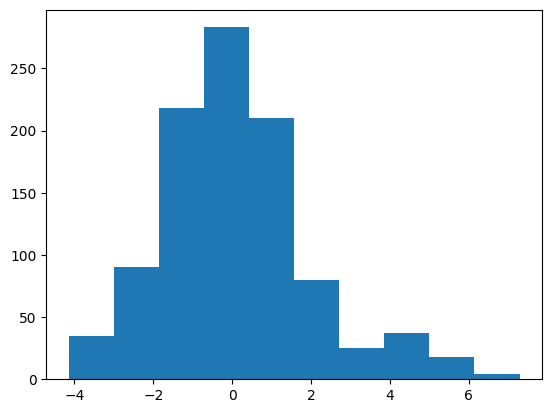

In [34]:
plt.hist(sampler.samples.flatten());

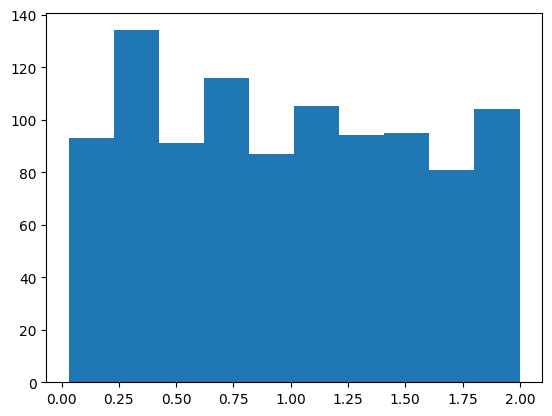

In [35]:
plt.hist(np.concatenate([constrain_bounded(sampler.samples[i], a, b) for i in range(sampler.samples.size)]));

# QuadLD

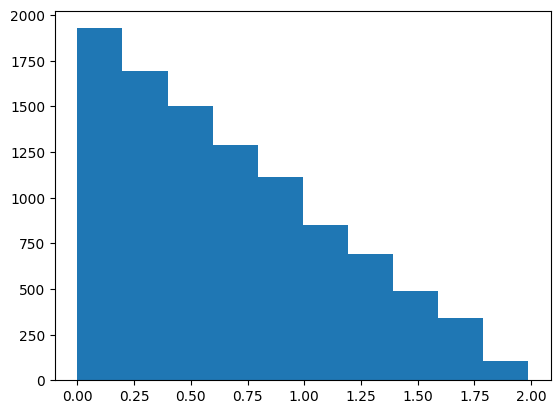

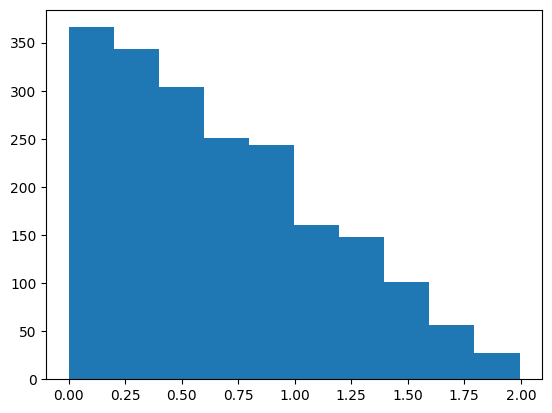

In [36]:
plt.hist(numpyro_ext.distributions.QuadLDParams().sample(zero_key, (10000,))[:, 0])
plt.show()

#  Two values are sampled from a uniform distribution between [0,1]. This is line 217 of Dan's code:
#      q = jax.random.uniform(key, shape=sample_shape + (2,), minval=0, maxval=1)
# 2. To transform from this q-space to u-space, we first do (the q2u function in Dan's code):
#     q1 = jnp.sqrt(q[0])  (This q1 variable in the code is the square root of the q1 in the paper)
#     q2 = 2 * q[1] (This q2 variable in the code is twice the value of the q2 in the paper)
# 3. We can then use these to calculate u1, u2:
#     u1 = q1 * q2
#     u2 = q1 * (1-q2)


q = distributions.Uniform().sample(zero_key, (4000,)).reshape(-1, 2)
q1 = jnp.sqrt(q[:, 0])
q2 = 2*q[..., 1]
u1 = q1*q2
u2 = q1*(1-q2)
plt.hist(u1);

In [37]:
q = distributions.Uniform().sample(zero_key, (4000,)).reshape(-1, 2)
u = numpyro_ext.distributions.QuadLDTransform()(q)

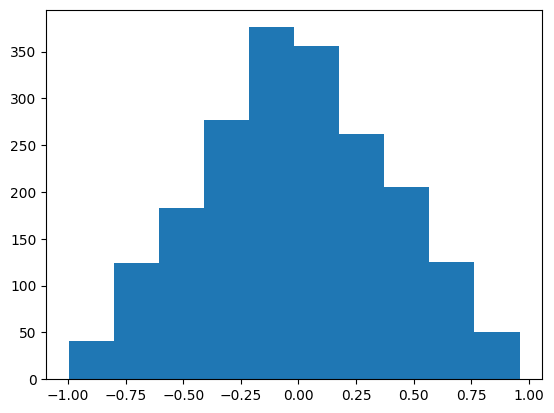

In [38]:
plt.hist(u[..., 1]);

# Jaxoplanet

In [39]:
# # def log_prob_model(params, data):
    
# #     y_obs, t, yerr = data
# #     t0, period, duration, r, b, u0, u1 = params
# #     u = jnp.array([u0, u1])
    
# #     log_prior = 0. 
# #     log_prior += dist.Normal(T0, 1).log_prob(t0)
# #     log_prior += dist.Normal(jnp.log(PERIOD), 0.1).log_prob(jnp.log(period))
# #     log_prior += dist.Normal(jnp.log(DURATION), 0.1).log_prob(jnp.log(duration))
# #     # log_prior += dist.Uniform(0.01, 0.2).log_prob(r)
# #     # log_prior += dist.Uniform(0, 1.0).log_prob(b / (1+r))
# #     log_prior += dist.Normal(jnp.log(ROR), 0.5).log_prob(jnp.log(r))
# #     log_prior += dist.Normal(-0.5, 0.5).log_prob(jnp.log(b / (1+r)))
# #     log_prior += numpyro_ext.distributions.QuadLDParams().log_prob(u)
       
# #     # The orbit and light curve
# #     orbit = TransitOrbit(
# #         period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
# #     )
# #     y_pred = limb_dark_light_curve(orbit, u)(t)
# #     log_likelihood = dist.Normal(y_pred, yerr).log_prob(y_obs)
    
# #     log_prob = log_prior + log_likelihood
    
# #     return jnp.sum(log_prob)

# # log_prob_model_grad = jax.grad(log_prob_model, argnums=0)


# def log_prob_model(params, data):
    
#     y_obs, t, yerr = data
#     t0, period, duration, r, b, u0, u1 = params
#     u = jnp.array([u0, u1])
    
#     log_prior = 0. 
#     log_prior += dist.Normal(T0, 1).log_prob(t0)
#     log_prior += dist.Normal(jnp.log(PERIOD), 0.1).log_prob(jnp.log(period))
#     log_prior += dist.Normal(jnp.log(DURATION), 0.1).log_prob(jnp.log(duration))
#     # log_prior += dist.Uniform(0.01, 0.2).log_prob(r)
#     # log_prior += dist.Uniform(0, 1.0).log_prob(b / (1+r))
    
#     # log_prior += dist.Normal(jnp.log(ROR), 0.5).log_prob(jnp.log(r))
#     # log_prior += dist.Normal(-0.5, 0.5).log_prob(jnp.log(b / (1+r)))
#     # log_prior += numpyro_ext.distributions.QuadLDParams().log_prob(u)
       
#     # The orbit and light curve
#     orbit = TransitOrbit(
#         period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
#     )
#     y_pred = limb_dark_light_curve(orbit, u)(t)
#     log_likelihood = dist.Normal(y_pred, yerr).log_prob(y_obs)
    
#     log_prob = log_prior + log_likelihood
    
#     return jnp.sum(log_prob)

# log_prob_model_grad = jax.grad(log_prob_model, argnums=0)

In [40]:
#
posterior_samples = []
for key in var_names:
    print(key)
    if key == 'u':
        posterior_samples.append(posterior_samples_nuts[key])
    else:        
        posterior_samples.append(np.expand_dims(posterior_samples_nuts[key], axis=1))
    
posterior_samples = np.concatenate(posterior_samples, axis=1)

#
prior_samples = []
for key in var_names:
    if key == 'u':
        prior_samples.append(converted_prior_samples[key][0])
    else:        
        prior_samples.append(np.expand_dims(converted_prior_samples[key][0], axis=1))
    
prior_samples = np.concatenate(prior_samples, axis=1)

t0
period
duration
r
b
u


In [41]:
class JaxPlanet():
    
    def __init__(self, yobs, t, yerr, 
                T0, PERIOD, DURATION,
                radius_limits=[0.01, 0.2], 
                rawb_limits=[0.0, 1.], 
                q_limits=[0., 1.]):
        
        self.yobs = yobs
        self.t = t
        self.yerr = yerr
        self.T0, self.PERIOD, self.DURATION = T0, PERIOD, DURATION

        self.transform_radius = constrain_bounded_bijector(radius_limits[0], radius_limits[1])
        self.transform_rawb = constrain_bounded_bijector(rawb_limits[0], rawb_limits[1])
        self.transform_q = constrain_bounded_bijector(q_limits[0], q_limits[1])
        self.dist_radius = distributions.Uniform(radius_limits[0], radius_limits[1])
        self.dist_rawb = distributions.Uniform(rawb_limits[0], rawb_limits[1])
        self.dist_q = distributions.Uniform(q_limits[0], q_limits[1])
        
    def constrain_period(self, log_period):
        return jnp.exp(log_period)
    
    def constrain_duration(self, log_duration):
        return jnp.exp(log_duration)
    
    def constrain_radius(self, radius_u):
        radius = self.transform_radius(radius_u)
        return radius
    
    def constrain_rawb(self, rawb_u):
        rawb = self.transform_rawb(rawb_u)
        return rawb

    def constrain_q(self, q_u):
        q = self.transform_q(q_u)
        return q

    def transform_parameters(self, params):
        assert len(params.shape) == 2
        t0_u, period_u, duration_u, r_u, rawb_u, q0_u, q1_u = params
        t0 = t0_u 
        period = self.constrain_period(period_u)
        duration = self.constrain_duration(duration_u)
        r = self.constrain_radius(r_u)
        rawb = self.constrain_rawb(rawb_u)
        b = rawb * (1 + r)
        q0 = self.constrain_q(q0_u)
        q1 = self.constrain_q(q1_u)
        q = jnp.stack([q0, q1]).T
        u = numpyro_ext.distributions.QuadLDTransform()(q)
        # return t0, period, duration, r, b, u[0], u[1]
        return jnp.array([t0, period, duration, r, b, u[..., 0], u[..., 1]]).T

    
    def log_prob_model(self, params):
        
        t0_u, period_u, duration_u, r_u, rawb_u, q0_u, q1_u = params
                    
        log_prior = 0. 
        log_prior += distributions.Normal(self.T0, 1).log_prob(t0_u)
        log_prior += distributions.Normal(jnp.log(self.PERIOD), 0.1).log_prob(period_u)
        log_prior += distributions.Normal(jnp.log(self.DURATION), 0.1).log_prob(duration_u)

        r = self.constrain_radius(r_u)
        lp_r = self.dist_radius.log_prob(r)
        ldj_r = self.transform_radius.forward_log_det_jacobian(r_u)
        log_prior += lp_r + ldj_r
        
        rawb = self.constrain_rawb(rawb_u)
        b = rawb * (1 + r)
        lp_rawb = self.dist_radius.log_prob(rawb)
        ldj_rawb = self.transform_radius.forward_log_det_jacobian(rawb_u)
        log_prior += lp_rawb + ldj_rawb
        
        q0 = self.constrain_q(q0_u)
        q1 = self.constrain_q(q1_u)
        q = jnp.stack([q0, q1])
        u = numpyro_ext.distributions.QuadLDTransform()(q)
        lp_u = numpyro_ext.distributions.QuadLDParams().log_prob(u)
        ldj_q = self.transform_q.forward_log_det_jacobian(q0_u) + self.transform_q.forward_log_det_jacobian(q1_u)
        ldj_u = numpyro_ext.distributions.QuadLDTransform().log_abs_det_jacobian(q, 0.)
        log_prior += lp_u + ldj_q + ldj_u 
 
        # return log_prior

        # The orbit and light curve
        period = self.constrain_period(period_u)
        duration = self.constrain_duration(duration_u)
        t0 = t0_u*1.
                                       
        orbit = TransitOrbit(
            period=period, duration=duration, time_transit=t0, impact_param=b, radius=r
        )
        y_pred = limb_dark_light_curve(orbit, u)(self.t)
        log_likelihood = jnp.sum(distributions.Normal(y_pred, self.yerr).log_prob(self.yobs))

        log_prob = log_prior + log_likelihood

        return log_prob

    

In [42]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/home/cmodi/miniconda3/envs/jaxlatest/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [43]:
planet = JaxPlanet(y.astype(float32), np.float32(t), np.float32(yerr), 
               T0=np.float32(T0), PERIOD=np.float32(PERIOD), DURATION=np.float32(DURATION))
truths= jnp.array([T0, PERIOD, DURATION, ROR, B, U[0], U[1]], dtype=float32)
var_names=["t0", "period", "duration", "r", "b", "u"]
truths

Array([1.8967748, 4.321868 , 0.5      , 0.08     , 0.5      , 0.1      ,
       0.06     ], dtype=float32)

In [44]:
# x0 = np.random.normal(0, 1, truths.size)
# planet.transform_parameters(x0)

In [45]:
lp = jax.jit(planet.log_prob_model)
lp_g = jax.jit(jax.grad(planet.log_prob_model))
# lp_g = lambda x: jax.grad(planet.log_prob_model)(x.astype(float32)).flatten().astype(float32)
# log_prob
# lp_g = lambda x: jax.jit(jax.grad(planet.log_prob_model)(x).flatten())


In [46]:
q0 = truths.copy()
lp(q0), lp_g(q0)

(Array(-4747.30779885, dtype=float64),
 Array([  283.59668,  -285.81802, -6300.5693 , -7536.536  ,  2929.366  ,
          290.43088,   359.54385], dtype=float32))

In [50]:
# q0 = [init_params['t0'], 
#       init_params['logP'], 
#       init_params['logD'],
#       planet.transform_radius.inverse(np.exp(init_params['logR'])),
#       planet.transform_rawb.inverse(init_params['_b']),
#       *planet.transform_q.inverse(numpyro_ext.distributions.QuadLDTransform().inv(truths[-2:]))]
# q0 = jnp.array(q0)
# q0

q0 = [T0,
      np.log(PERIOD),
      np.log(DURATION),
      planet.transform_radius.inverse(ROR),
      planet.transform_rawb.inverse(B*(1 + ROR)),
      *planet.transform_q.inverse(numpyro_ext.distributions.QuadLDTransform().inv(truths[-2:]))]
q0 = jnp.array(q0).astype(float32)
q0

Array([ 1.8967748 ,  1.4636878 , -0.6931472 , -0.5389965 ,  0.16034275,
       -3.6392298 , -0.78845733], dtype=float32)

## Try HMC with it

In [51]:
# kernel = HMC(1, lp_uniform, lp_g)
kernel = HMC(7, lp, lp_g, dtype=float32)
sampler = kernel.sample(q0, step_size=0.01, n_samples=5000, burnin=100, nleap=100, n_stepsize_adapt=500, verbose=True)

Adapting step size for 500 iterations
Step size fixed to :  0.0002577150620646177


In [52]:
np.unique(sampler.accepts, return_counts=True)

(array([-1.,  1.]), array([ 697, 4303]))

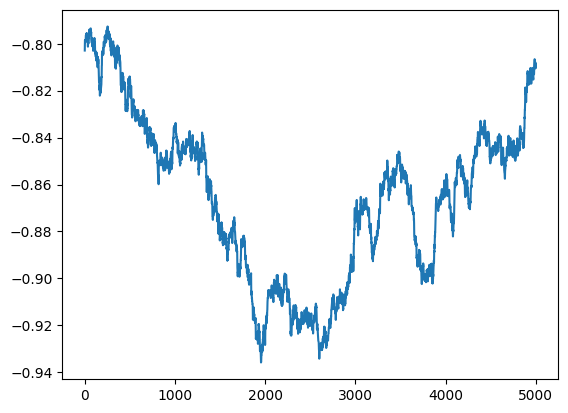

In [53]:
d = 6
plt.plot(sampler.samples[:, d])


In [54]:
s = planet.transform_parameters(sampler.samples.T)

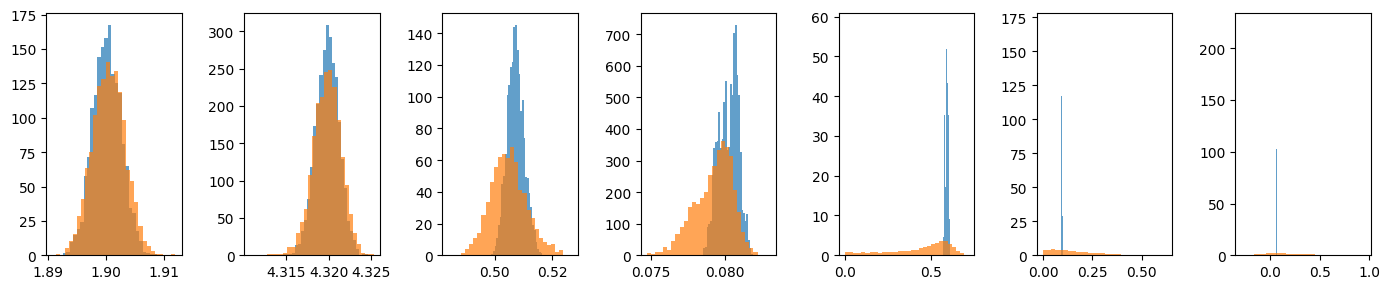

In [55]:
fig, ax = plt.subplots(1, 7, figsize=(14, 3), sharex='col')
                       
for d in range(7):
        ax[d].hist(s[..., d], alpha=0.7, density=True, bins=30)
        ax[d].hist(posterior_samples[..., d], alpha=0.7, density=True, bins=30);
        # ax[d].hist(prior_samples[..., d], alpha=0.7, density=True, bins=30);
                    
plt.tight_layout()

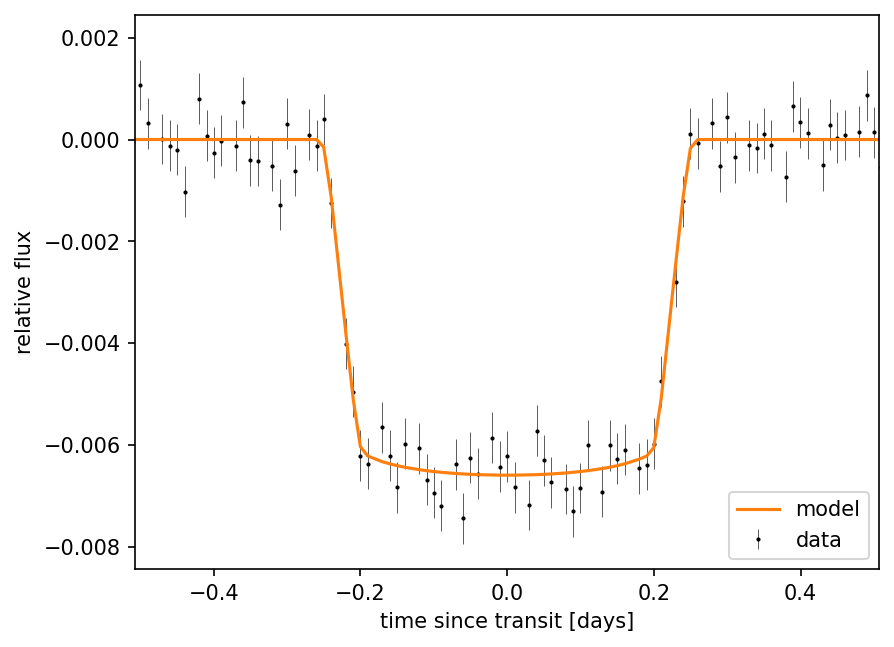

In [56]:
inferred_t0 = np.median(s[:, 0])
inferred_period = np.median(s[:, 1])
inferred_duration = np.median(s[:, 2])
inferred_r = np.median(s[:, 3])
inferred_b = np.median(s[:, 4])
inferred_u = np.median(s[:, 5:], axis=0)

orbit = TransitOrbit(
    period=inferred_period,
    duration=inferred_duration,
    time_transit=inferred_t0,
    impact_param=inferred_b,
    radius=inferred_r,
)
y_model = limb_dark_light_curve(orbit, inferred_u)(t)


fig, ax = plt.subplots(dpi=150)

# Plot the folded data
t_fold = (
    t - inferred_t0 + 0.5 * inferred_period
) % inferred_period - 0.5 * inferred_period
ax.errorbar(
    t_fold,
    y,
    yerr=yerr,
    marker=".",
    ls="none",
    color="k",
    capsize=0,
    ms=2,
    lw=0.3,
    alpha=1,
    label="data",
    zorder=-100,
)

# Plot the folded model
inds = np.argsort(t_fold)
ax.plot(t_fold[inds], y_model[inds], color="C1", lw=1.5, label="model")
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux")
ax.legend(fontsize=10, loc=4)
ax.set_xlim(-inferred_duration, inferred_duration);

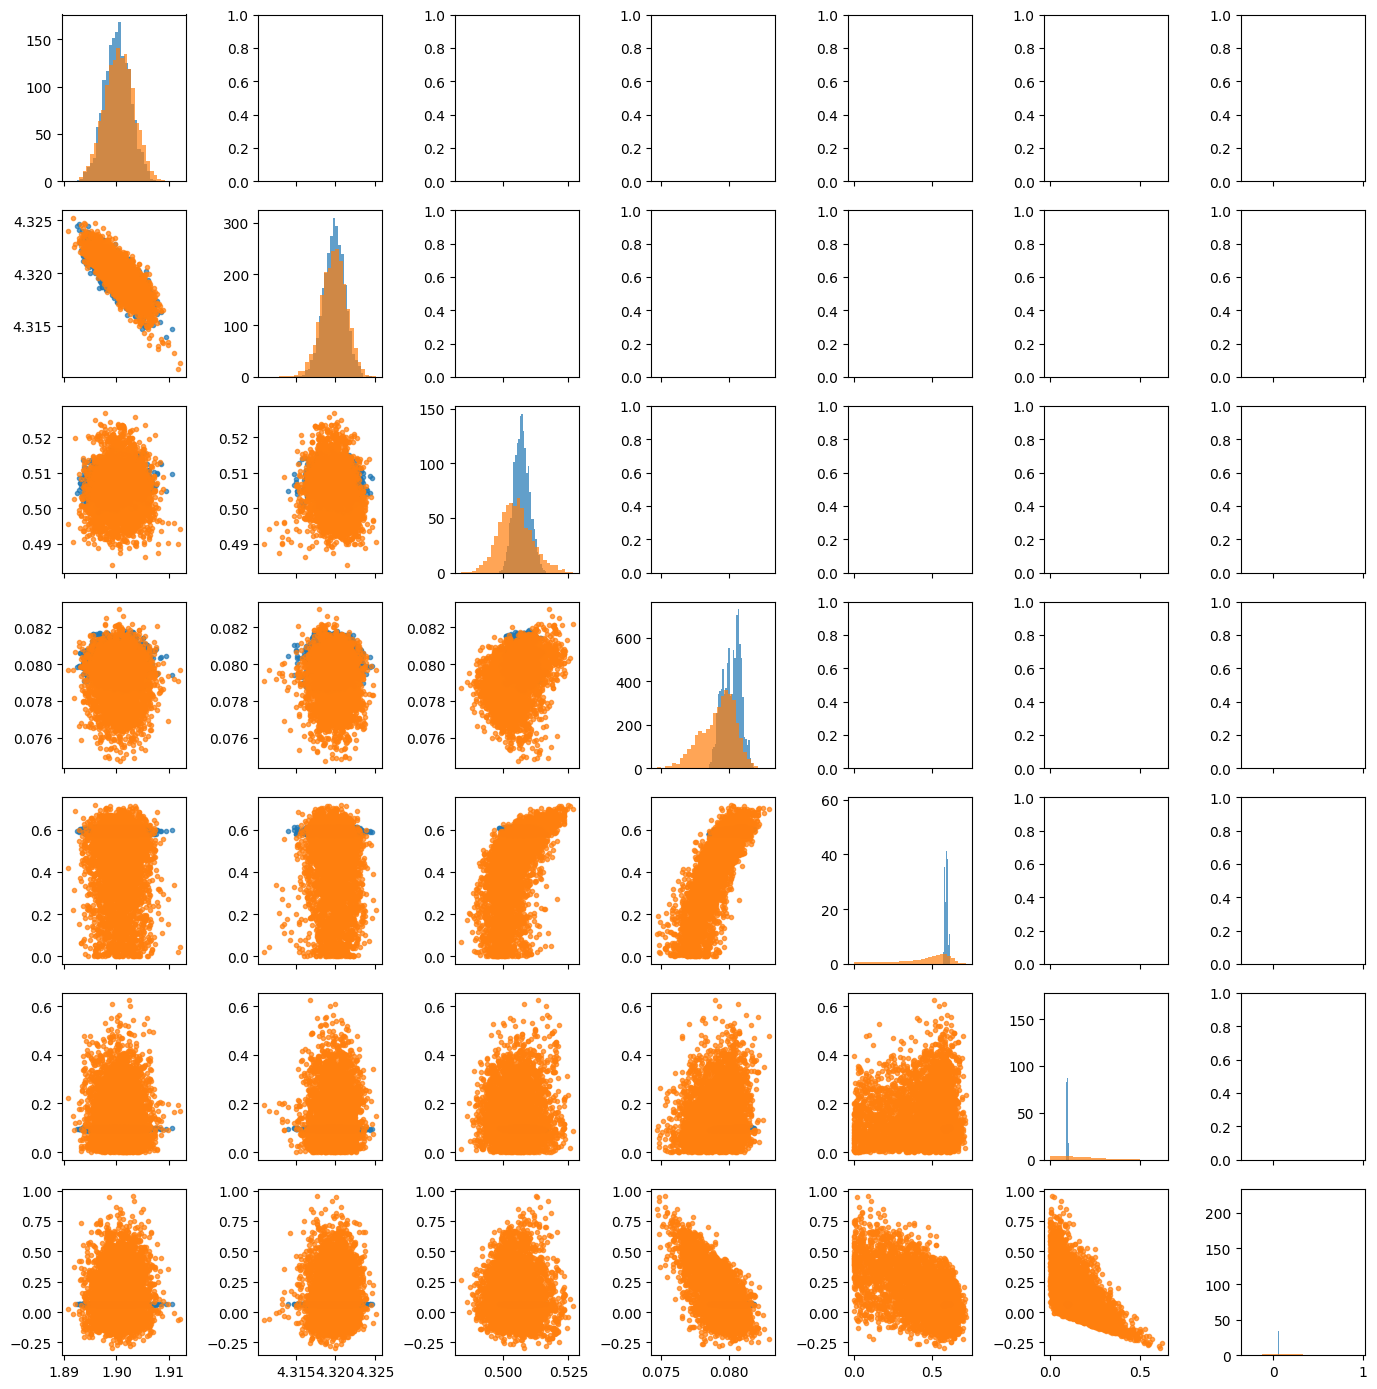

In [57]:
# fig, ax = plt.subplots(7, 7, figsize=(14, 14), sharex='col')
                       
# for d in range(7):
#     for i in range(d, 7):
#         if i == d:
#             ax[d, d].hist(s[..., d], alpha=0.7, density=True, bins=30)
#             ax[d, d].hist(prior_samples[..., d], alpha=0.7, density=True, bins=30);
#         else:
#             ax[i, d].plot(s[..., d], s[..., i], '.', alpha=0.7)
#             ax[i, d].plot(prior_samples[..., d], prior_samples[..., i], '.', alpha=0.7)
            
# plt.tight_layout()

fig, ax = plt.subplots(7, 7, figsize=(14, 14), sharex='col')
                       
for d in range(7):
    for i in range(d, 7):
        if i == d:
            ax[d, d].hist(s[..., d], alpha=0.7, density=True, bins=30)
            ax[d, d].hist(posterior_samples[..., d], alpha=0.7, density=True, bins=30);
        else:
            ax[i, d].plot(s[..., d], s[..., i], '.', alpha=0.7)
            ax[i, d].plot(posterior_samples[..., d], posterior_samples[..., i], '.', alpha=0.7)
            
plt.tight_layout()

# VI 

In [58]:
q0.size

7

In [60]:
q0 = [init_params['t0'], 
      init_params['logP'], 
      init_params['logD'],
      planet.transform_radius.inverse(np.exp(init_params['logR'])),
      planet.transform_rawb.inverse(init_params['_b']),
      *planet.transform_q.inverse(numpyro_ext.distributions.QuadLDTransform().inv(truths[-2:]))]
q0 = jnp.array(q0).astype(float32)
print(q0)

q0 = [T0,
      np.log(PERIOD),
      np.log(DURATION),
      planet.transform_radius.inverse(ROR),
      planet.transform_rawb.inverse(B/(1 + ROR)),
      *planet.transform_q.inverse(numpyro_ext.distributions.QuadLDTransform().inv(truths[-2:]))]
q0 = jnp.array(q0).astype(float32)
q0

[ 1.8967748   1.4636878  -0.6931472  -0.5389965  -0.14841998 -3.6392298
 -0.78845733]


Array([ 1.8967748 ,  1.4636878 , -0.6931472 , -0.5389965 , -0.14841998,
       -3.6392298 , -0.78845733], dtype=float32)

In [108]:
import sys
sys.path.append('../gsmvi/')
from gsm import GSM
from functools import partial


D = 7 

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg = GSM(D, lp, lp_g)
alg = GSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
mean, cov = alg.fit(key, mean=q0, cov=np.eye(D).astype(float32)*0.001, batch_size=16, niter=1000)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000


In [114]:
vi_samples = planet.transform_parameters(np.random.multivariate_normal(mean, cov, 4000).T)


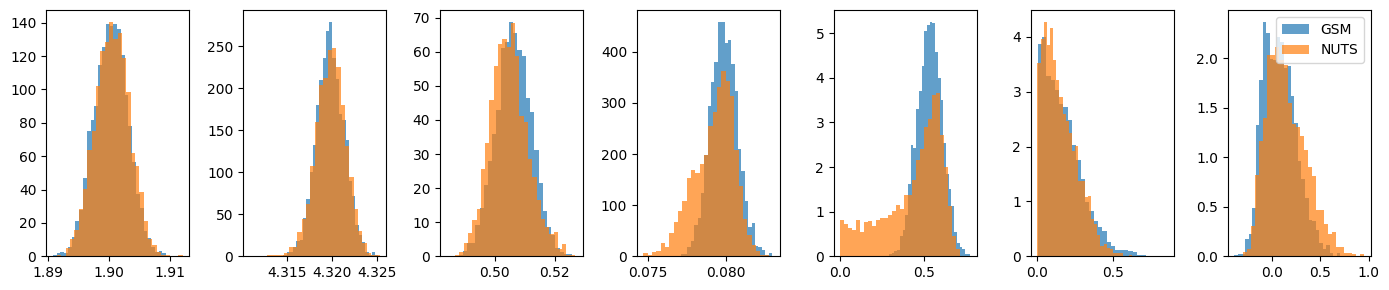

In [115]:
fig, ax = plt.subplots(1, 7, figsize=(14, 3), sharex='col')
                       
for d in range(7):
        # ax[d].hist(s[..., d], alpha=0.7, density=True, bins=30)
        ax[d].hist(vi_samples[..., d], alpha=0.7, density=True, bins=30, label='GSM');
        ax[d].hist(posterior_samples[..., d], alpha=0.7, density=True, bins=30, label='NUTS');
        # ax[d].hist(prior_samples[..., d], alpha=0.7, density=True, bins=30);
                    
plt.tight_layout()
plt.legend()


In [130]:
var_names2 = var_names[:-1] + ['u0', 'u1']

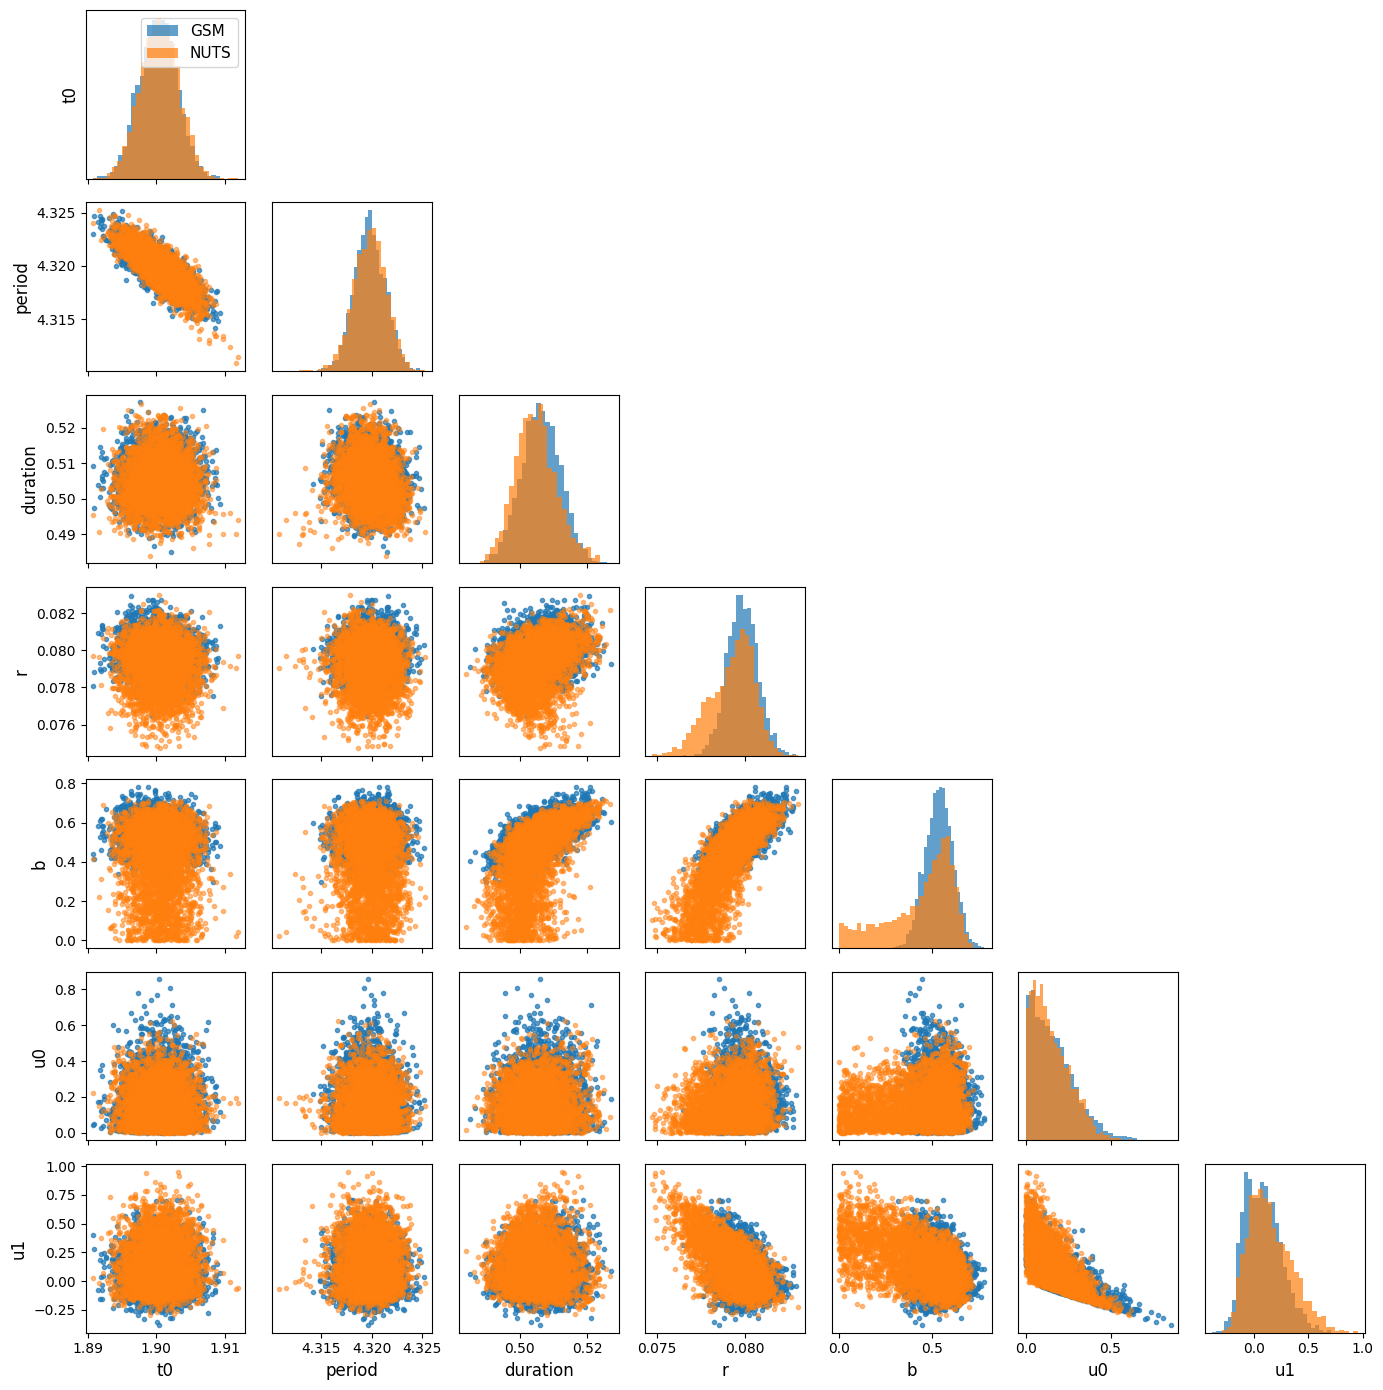

In [134]:
fig, ax = plt.subplots(7, 7, figsize=(14, 14), sharex='col')
                       
for d in range(7):
    for i in range(d, 7):
        if i == d:
            ax[d, d].hist(vi_samples[..., d], alpha=0.7, density=True, bins=30, label='GSM')
            ax[d, d].hist(posterior_samples[..., d], alpha=0.7, density=True, bins=30, label='NUTS');
            # ax[d, d].set_yticks('off')
            ax[d, d].get_yaxis().set_ticks([])
        else:
            ax[i, d].plot(vi_samples[..., d], vi_samples[..., i], '.', alpha=0.7)
            ax[i, d].plot(posterior_samples[..., d], posterior_samples[..., i], '.', alpha=0.5)
            ax[d, i].axis('off')
            if d >0  : ax[i, d].get_yaxis().set_ticks([])

ax[0, 0].legend(fontsize=11)
for ia, axis in enumerate(ax[:, 0]): 
    axis.set_ylabel(var_names2[ia], fontsize=12)
for ia, axis in enumerate(ax[-1, :]): 
    axis.set_xlabel(var_names2[ia], fontsize=12)
plt.tight_layout()

## HMC again with mass matrix

In [64]:
M = cov.copy()
# kernel = HMC(1, lp_uniform, lp_g)

kernel = HMC(7, lp, lp_g, dtype=float32, mass_matrix=M)
sampler = kernel.sample(q0, step_size=0.01, n_samples=5000, burnin=100, nleap=100, n_stepsize_adapt=500, verbose=True)

Adapting step size for 500 iterations
Step size fixed to :  0.5480347669164423


In [65]:
s = planet.transform_parameters(sampler.samples.T)

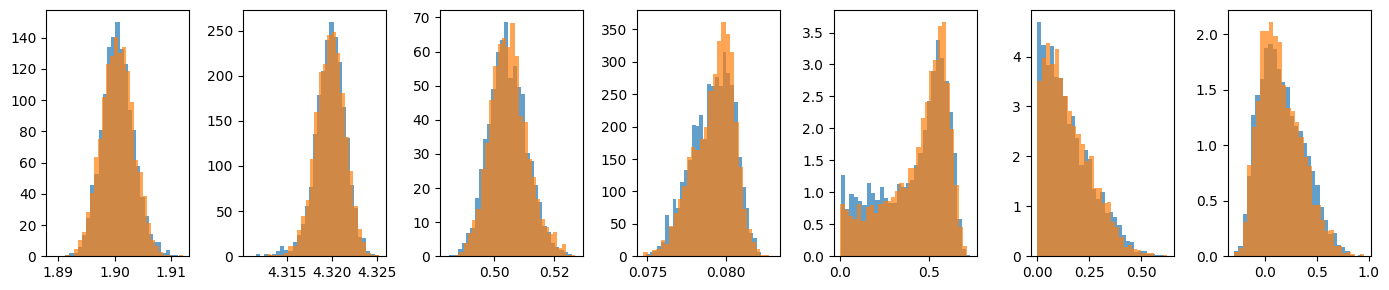

In [66]:
fig, ax = plt.subplots(1, 7, figsize=(14, 3), sharex='col')
                       
for d in range(7):
        ax[d].hist(s[..., d], alpha=0.7, density=True, bins=30)
        ax[d].hist(posterior_samples[..., d], alpha=0.7, density=True, bins=30);
        # ax[d].hist(prior_samples[..., d], alpha=0.7, density=True, bins=30);
                    
plt.tight_layout()

In [ ]:
s.shape

(5000, 7)

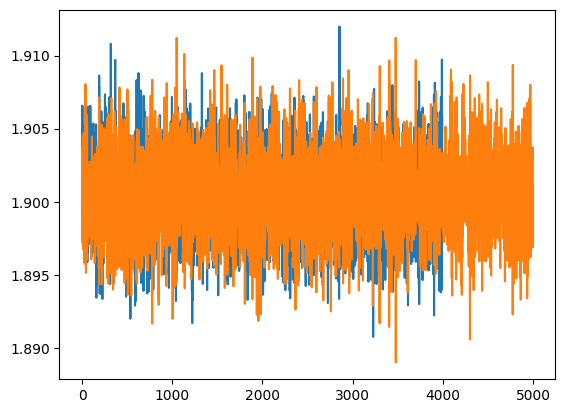

In [ ]:
d = 0 
plt.plot(posterior_samples[..., d])
plt.plot(s[..., d])

In [138]:
# d = 3 
# plt.plot(az.autocorr(posterior_samples[..., d]))
# plt.plot(az.autocorr(posterior_samples[:2000, d]))
# plt.plot(az.autocorr(posterior_samples[2000:, d]))
# plt.plot(az.autocorr(s[:, d]), 'k')
# plt.xlim(0, 50)
# plt.grid(which='both')

In [136]:
# np.save('/mnt/ceph/users/cmodi/ls-gsm/jaxoplanet_nuts_samples', posterior_samples)